### GIS-2 Final Project


Step 1: Data acquisition and cleaning 

In [42]:
#!pip install geopandas osmnx requests pandas numpy shapely matplotlib pathlib seaborn rasterstats folium keplergl scipy networkx

In [43]:
# Import necessary libraries for GIS data processing
import geopandas as gpd
import osmnx as ox
import rasterio
from rasterio.features import shapes
from rasterio.mask import mask
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject, Resampling
import requests
import zipfile
import os
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
from pathlib import Path
import json
import seaborn as sns
from rasterstats import zonal_stats
import folium
from folium.plugins import HeatMap
import warnings
from keplergl import KeplerGl
from scipy.interpolate import griddata
warnings.filterwarnings('ignore')
import networkx as nx


# Set up OSMnx settings
ox.settings.log_console = True
ox.settings.use_cache = True

# Define data directory
DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)

# Define place name
PLACE_NAME = 'Graz, Austria'

# Define CRS for metric projections
# For Austria: EPSG:31256 (MGI / Austria Lambert) is recommended for official geodetic work
# Alternative: EPSG:32633 (UTM zone 33N) - but less accurate for Austria
CRS_METRIC = 'EPSG:31256'  # MGI / Austria Lambert - official Austrian CRS

In [44]:
# Load Graz city boundary and districts
graz_boundary = ox.geocode_to_gdf(PLACE_NAME).to_crs(CRS_METRIC)

# All 17 districts of Graz
OFFICIAL_DISTRICTS = [
    "Innere Stadt", "St. Leonhard", "Sankt Leonhard", "Geidorf", "Lend", "Gries",
    "Jakomini", "Liebenau", "St. Peter", "Sankt Peter", "Waltendorf", "Ries",
    "Mariatrost", "Andritz", "Gösting", "Eggenberg", "Wetzelsdorf", "Straßgang", "Puntigam"
]

# Get administrative boundaries from OSM and filter to Graz districts
all_admin = ox.features_from_place(PLACE_NAME, tags={'boundary': 'administrative'})
all_admin = all_admin[all_admin.geometry.type.isin(['Polygon', 'MultiPolygon'])].to_crs(CRS_METRIC)

districts = all_admin[all_admin['name'].isin(OFFICIAL_DISTRICTS)][['name', 'geometry']].copy()
districts = districts[districts.is_valid].reset_index(drop=True)

print(f"✓ Loaded {len(districts)} districts (total available: {len(OFFICIAL_DISTRICTS)})")

✓ Loaded 17 districts (total available: 19)


In [45]:
# Load medical facilities from OSM
print("Loading medical facilities...")

# Load medical facilities from OSM and convert to metric CRS
medical = ox.features_from_place(
    PLACE_NAME,
    tags={'amenity': ['hospital', 'clinic', 'doctors', 'pharmacy']}
).to_crs(CRS_METRIC)

# Separate points and polygons
medical_points = medical[medical.geometry.type == 'Point']
medical_polygons = medical[medical.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Use centroids for polygon geometries
medical_polygons = medical_polygons.copy()
medical_polygons['geometry'] = medical_polygons.geometry.centroid

# Combine points and centroids into one GeoDataFrame
medical = pd.concat([medical_points, medical_polygons], ignore_index=True)

# Remove duplicates
medical['geom_str'] = medical['geometry'].astype(str)
medical = medical.drop_duplicates(subset=['geom_str']).drop('geom_str', axis=1)



# Inspect key OSM columns
print("Columns present:",
      [c for c in medical.columns
       if c in ['amenity', 'healthcare', 'healthcare:speciality']])

# Unique main amenity types
print("amenity:", sorted(medical['amenity'].dropna().unique()))

# Unique healthcare types (if present)
if 'healthcare' in medical.columns:
    print("healthcare:", sorted(medical['healthcare'].dropna().unique()))

# Unique healthcare specialties (if present)
if 'healthcare:speciality' in medical.columns:
    print("healthcare:speciality:", sorted(medical['healthcare:speciality'].dropna().unique()))

# Check geometry types (Point vs Polygon)
medical_all = ox.features_from_place(
    PLACE_NAME,
    tags={'amenity': ['hospital', 'clinic', 'doctors', 'pharmacy']}
)
print(medical_all.geometry.type.value_counts())



# Classify facility type
def classify_facility(row):
    name = str(row.get('name', '')).lower()
    amenity = str(row.get('amenity', '')).lower()
    if 'hospital' in name or 'krankenhaus' in name: return 'Hospital'
    if amenity == 'pharmacy' or 'apotheke' in name: return 'Pharmacy'
    if amenity == 'doctors' or 'arzt' in name: return 'Doctor'
    return 'Clinic'

medical['type'] = medical.apply(classify_facility, axis=1)
medical = medical[['name', 'type', 'geometry']].dropna(subset=['name']).reset_index(drop=True)

print(f"✓ Total facilities: {len(medical)}")
for t in medical['type'].unique():
    print(f"  • {t}: {len(medical[medical['type'] == t])}")

Loading medical facilities...
Columns present: ['amenity', 'healthcare', 'healthcare:speciality']
amenity: ['clinic', 'doctors', 'hospital', 'pharmacy']
healthcare: ['alternative', 'blood_donation', 'centre', 'clinic', 'doctor', 'hospital', 'laboratory', 'pharmacy', 'physiotherapist', 'psychotherapist', 'therapist']
healthcare:speciality: ['acupuncture', 'acupuncture;general;neurology;psychiatry', 'anaesthetics', 'anaesthetics;general', 'anaesthetics;psychiatry;trauma', 'ayurveda', 'biochemistry', 'blood_check', 'cardiology', 'cardiology;internal', 'child_psychiatry;general', 'child_psychiatry;psychiatry;neurology;youth_psychiatry', 'dentist', 'dermatology', 'dermatology;dermatovenereology', 'dermatology;paediatrics;internal;orthopaedics;trauma;otolaryngology;dermatovenereology;psychiatry;neurology;anaesthetics', 'dermatovenereology', 'dermatovenereology;dermatology', 'dermatovenereology;dermatology;allergology', 'diagnostic_radiology;nuclear', 'dialysis', 'emergency', 'emergencyhealth

In [46]:
# Load street network and residential areas
print("Loading streets and residential areas...")

street_graph = ox.graph_from_place(PLACE_NAME, network_type='walk')

streets = ox.graph_to_gdfs(street_graph, nodes=False).to_crs(CRS_METRIC)
streets = streets[streets.is_valid].reset_index(drop=True)

residential = ox.features_from_place(PLACE_NAME, tags={'landuse': 'residential'})
residential = residential[residential.geometry.type.isin(['Polygon', 'MultiPolygon'])].to_crs(CRS_METRIC)
residential = residential[residential.is_valid].reset_index(drop=True)

print(f"✓ Streets: {len(streets)} | Residential areas: {len(residential)}")

Loading streets and residential areas...
✓ Streets: 98116 | Residential areas: 302


In [47]:
# Load ALL administrative boundaries
all_admin = ox.features_from_place(
    PLACE_NAME,
    tags={"boundary": "administrative"}
)

all_admin = all_admin[
    all_admin.geometry.type.isin(["Polygon", "MultiPolygon"])
].to_crs(CRS_METRIC)

# Official Graz districts (Stadtbezirke)
official_districts = [
    "Innere Stadt", "Sankt Leonhard", "Geidorf", "Lend", "Gries",
    "Jakomini", "Liebenau", "Sankt Peter", "Waltendorf", "Ries",
    "Mariatrost", "Andritz", "Gösting", "Eggenberg",
    "Wetzelsdorf", "Straßgang", "Puntigam"
]

districts = all_admin[all_admin["name"].isin(official_districts)].copy()

print("Number of districts:", len(districts))


Number of districts: 17


In [48]:
# Load population raster (GHSL)
print("Loading population data...")

ghsl_tif = Path(r'C:\Users\adily\FINAL\GIS_2_Final\GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R4_C20.tif')

if not ghsl_tif.exists():
    print(f"Error: File not found at {ghsl_tif}")
else:
    with rasterio.open(ghsl_tif) as src:
        graz_bounds = graz_boundary.to_crs(src.crs).total_bounds
        window = rasterio.windows.from_bounds(*graz_bounds, src.transform)
        pop_data = src.read(1, window=window)
        
        clipped_tif = DATA_DIR / 'graz_population.tif'
        with rasterio.open(clipped_tif, 'w', driver='GTiff', height=pop_data.shape[0], 
                          width=pop_data.shape[1], count=1, dtype=pop_data.dtype, 
                          crs=src.crs, transform=src.window_transform(window)) as dst:
            dst.write(pop_data, 1)
        
        print(f"✓ Population raster loaded and clipped")

Loading population data...
Error: File not found at C:\Users\adily\FINAL\GIS_2_Final\GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R4_C20.tif


## Step 2: Calculate & Visualize Distribution

In this step, we calculate the density and distribution of key categories:
- Medical facilities (hospitals, pharmacies, GPs, rescue stations)
- Population (from GHSL raster)
- Residential areas
- Street network

We use appropriate metrics:
- **Kernel Density Estimation (KDE)** for point-based data (medical facilities) to show smooth density surfaces.
- **Hexagonal binning** for aggregating point densities into hexagons for better visualization.
- **Choropleth maps** by districts for aggregated statistics (e.g., population density, facility counts per district).
- **Zonal statistics** for population raster aggregated to districts.

Visualizations include maps with color scales, legends, and overlays.

In [49]:
# Calculate population per district


print("Calculating population statistics by district...")

clipped_tif = DATA_DIR / 'graz_population.tif'
with rasterio.open(clipped_tif) as src:
    districts_proj = districts.to_crs(src.crs)
    stats = zonal_stats(districts_proj, str(clipped_tif), stats=['sum'])
    districts['population'] = [s.get('sum', 0) for s in stats]
    
    # Scale down if unrealistic
    if districts['population'].sum() > 500000:
        districts['population'] = districts['population'] / 10
    
    districts['area_km2'] = districts.geometry.area / 1_000_000
    districts['pop_density'] = districts['population'] / districts['area_km2'].clip(lower=0.1)

print(f"✓ Total population: {districts['population'].sum():.0f}")
print(f"✓ Average density: {districts['pop_density'].mean():.1f} people/km²")

Calculating population statistics by district...
✓ Total population: 316742
✓ Average density: 3663.8 people/km²


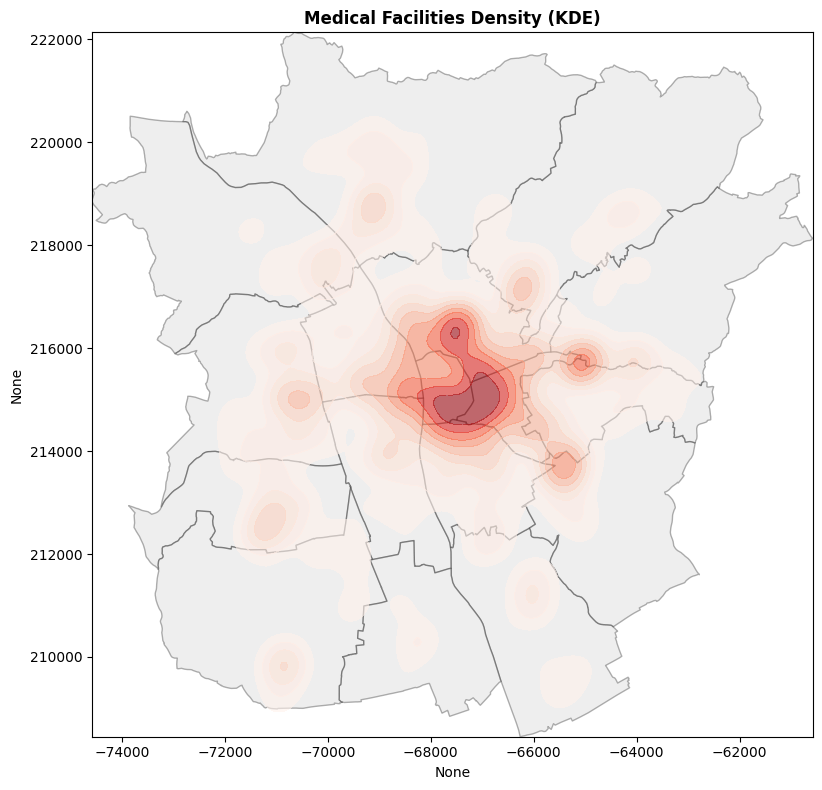

✓ KDE map saved


In [50]:
# KDE visualization - medical facilities density
bounds = graz_boundary.total_bounds

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
graz_boundary.plot(ax=ax, color='lightgray', alpha=0.5)
districts.plot(ax=ax, color='white', edgecolor='black', alpha=0.3)
sns.kdeplot(data=medical, x=medical.geometry.x, y=medical.geometry.y, 
            fill=True, cmap='Reds', alpha=0.6, ax=ax, bw_adjust=0.5)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Medical Facilities Density (KDE)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'medical_kde.png', dpi=300)
plt.show()

print("✓ KDE map saved")

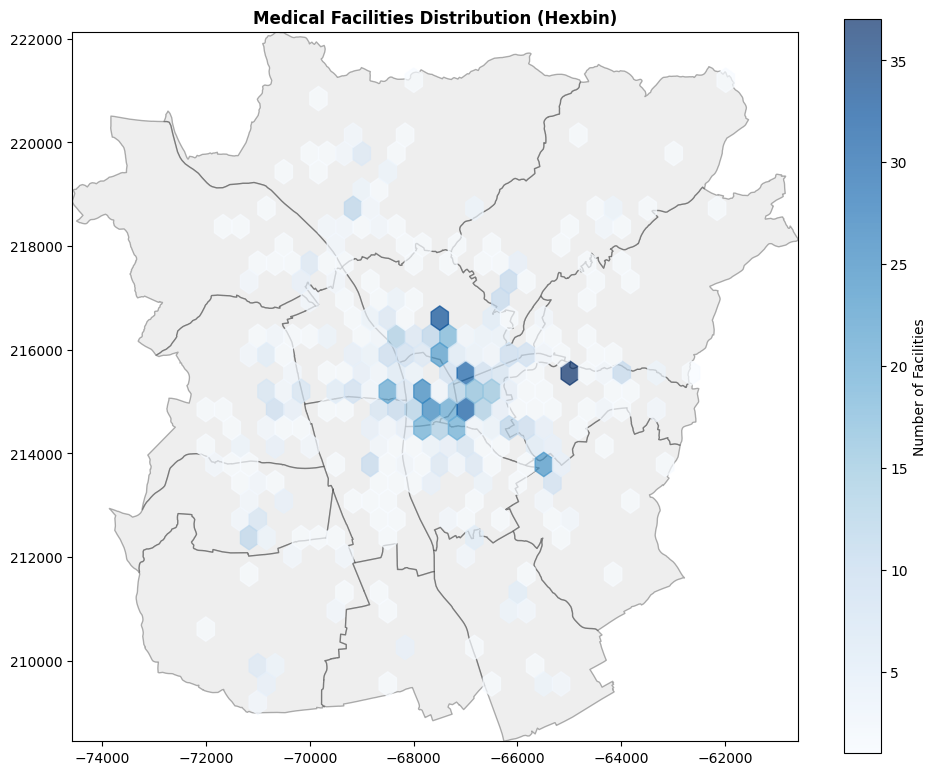

✓ Hexbin map saved


In [51]:
# Hexagonal binning visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
graz_boundary.plot(ax=ax, color='lightgray', alpha=0.5)
districts.plot(ax=ax, color='white', edgecolor='black', alpha=0.3)

hb = ax.hexbin(medical.geometry.x, medical.geometry.y, gridsize=30, cmap='Blues', alpha=0.7, mincnt=1)
plt.colorbar(hb, ax=ax, label='Number of Facilities')

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Medical Facilities Distribution (Hexbin)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'medical_hexbin.png', dpi=300)
plt.show()

print("✓ Hexbin map saved")

Creating medical facilities by district map...


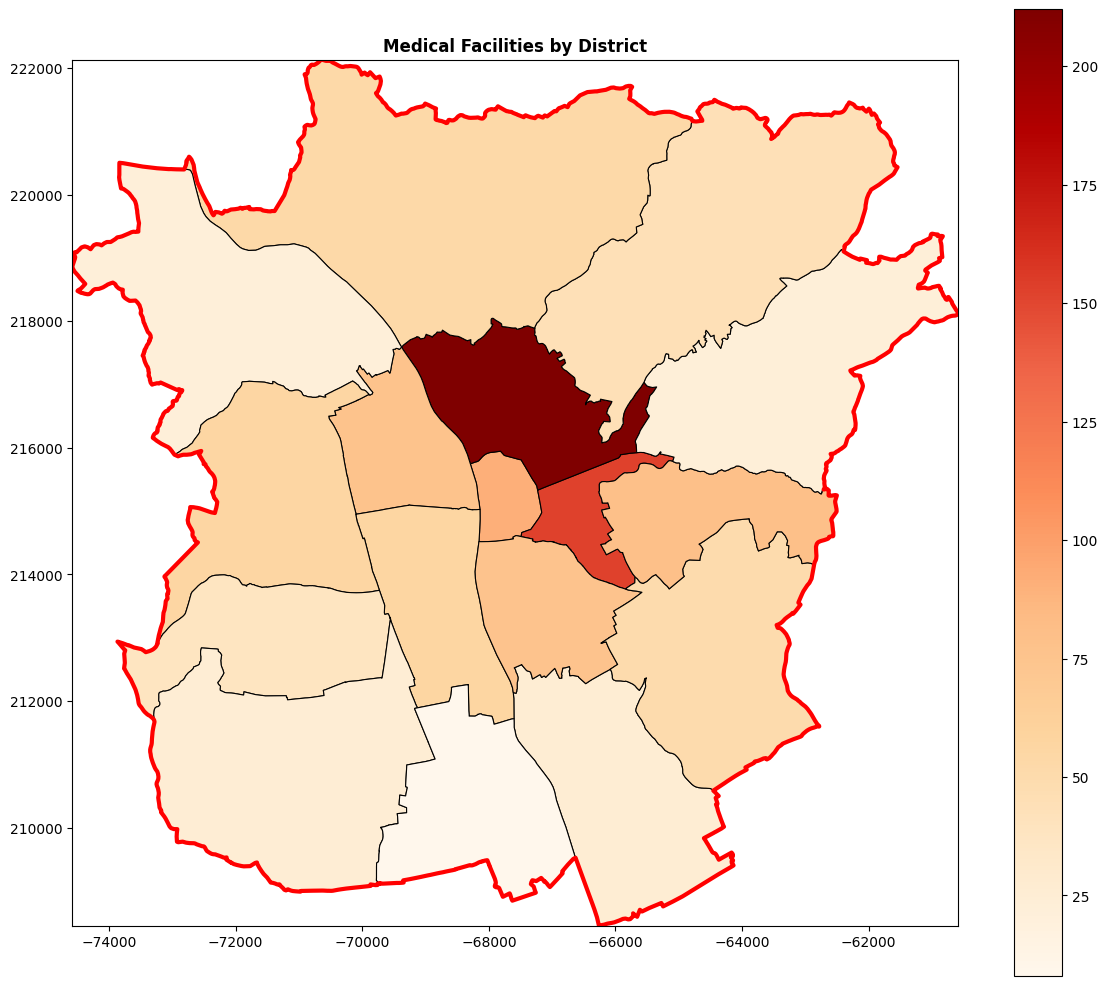

✓ Choropleth map saved


In [52]:
# Choropleth map - medical facilities by district
print("Creating medical facilities by district map...")

medical_in_districts = gpd.sjoin(medical, districts[['name', 'geometry']], how='left', predicate='within')
facility_counts = medical_in_districts['name_right'].value_counts().reset_index(name='count')
facility_counts.columns = ['name', 'count']

districts_stats = districts.copy()
districts_stats = districts_stats.merge(facility_counts, left_on='name', right_on='name', how='left')
districts_stats['count'] = districts_stats['count'].fillna(0).astype(int)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
districts_stats.plot(column='count', ax=ax, cmap='OrRd', legend=True, edgecolor='black', linewidth=0.8)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=3)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Medical Facilities by District', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'medical_by_district.png', dpi=150)
plt.show()

print("✓ Choropleth map saved")

Creating population by district map...


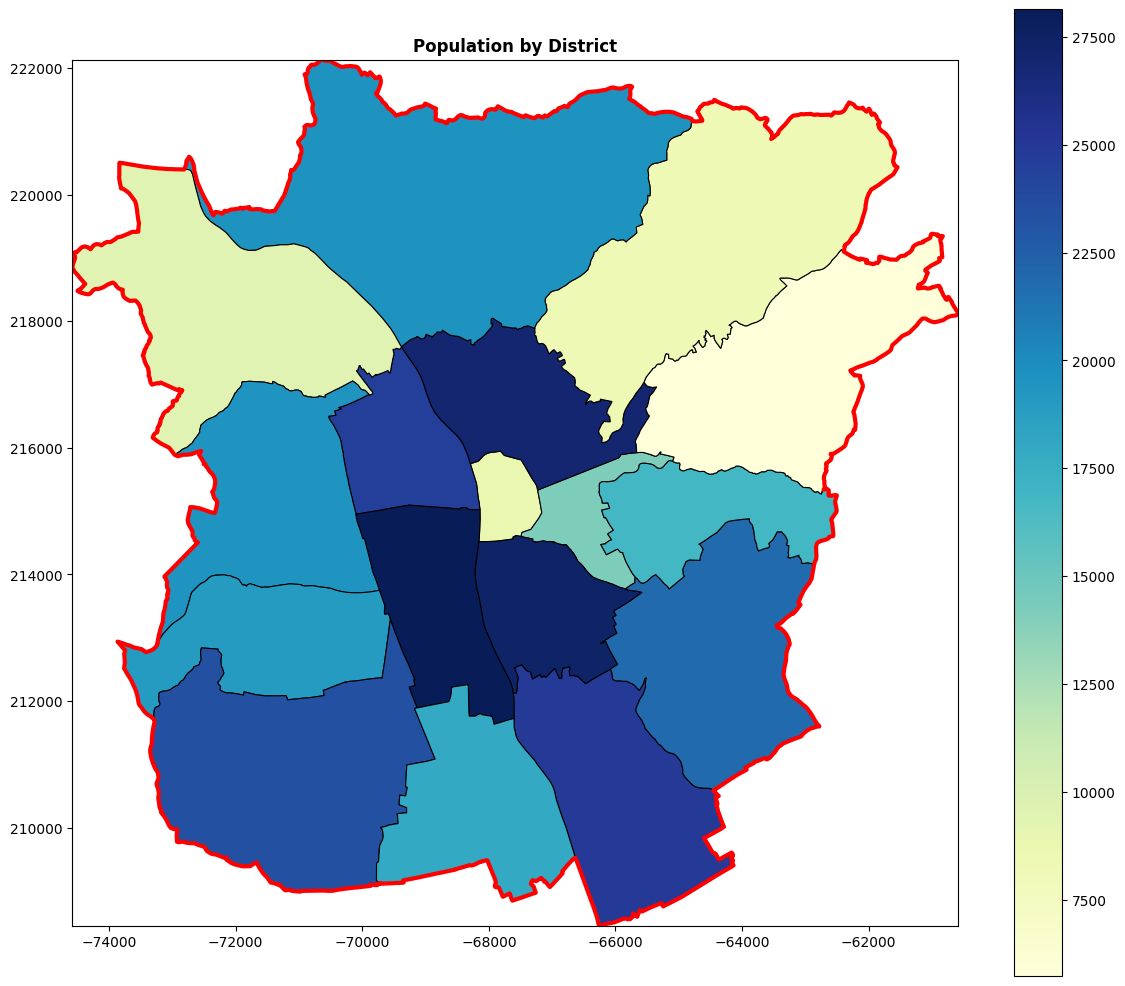

✓ Population map saved


In [53]:
# Choropleth map - population by district
print("Creating population by district map...")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
districts.plot(column='population', ax=ax, cmap='YlGnBu', legend=True, edgecolor='black', linewidth=0.8)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=3)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Population by District', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'population_by_district.png', dpi=150)
plt.show()

print("✓ Population map saved")

In [54]:
# Convert to WGS84 for web maps
print("Converting to WGS84 for web mapping...")

districts_wgs = districts.to_crs('EPSG:4326')
districts_stats_wgs = districts_stats.to_crs('EPSG:4326')
graz_boundary_wgs = graz_boundary.to_crs('EPSG:4326')
medical_wgs = medical.to_crs('EPSG:4326')

graz_center = graz_boundary_wgs.geometry.centroid.iloc[0]

print(f"✓ Map center: ({graz_center.y:.4f}, {graz_center.x:.4f})")

Converting to WGS84 for web mapping...
✓ Map center: (47.0751, 15.4394)


Creating statistics...


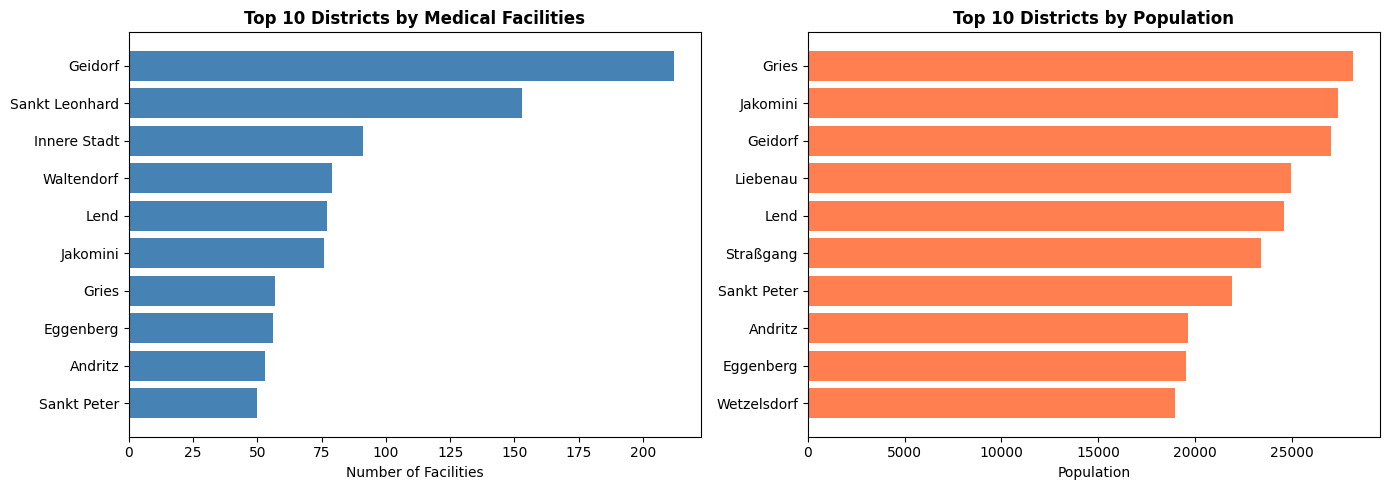


ANALYSIS SUMMARY
Total facilities: 1090
  • Pharmacy: 65
  • Doctor: 996
  • Clinic: 24
  • Hospital: 5

Total population: 316742
Total districts: 17


In [55]:
# Statistics and analysis
print("Creating statistics...")

# Top medical districts
medical_in_districts = gpd.sjoin(medical, districts[['name', 'geometry']], how='left', predicate='within')
fac_counts = medical_in_districts['name_right'].value_counts().reset_index(name='count')
fac_counts.columns = ['name', 'count']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Top 10 medical facilities districts
top_med = fac_counts.nlargest(10, 'count').sort_values('count')
ax1.barh(range(len(top_med)), top_med['count'].values, color='steelblue')
ax1.set_yticks(range(len(top_med)))
ax1.set_yticklabels(top_med['name'].values)
ax1.set_xlabel('Number of Facilities')
ax1.set_title('Top 10 Districts by Medical Facilities', fontweight='bold')

# Top 10 population districts
top_pop = districts.nlargest(10, 'population').sort_values('population')
ax2.barh(range(len(top_pop)), top_pop['population'].values, color='coral')
ax2.set_yticks(range(len(top_pop)))
ax2.set_yticklabels(top_pop['name'].values)
ax2.set_xlabel('Population')
ax2.set_title('Top 10 Districts by Population', fontweight='bold')

plt.tight_layout()
plt.savefig(DATA_DIR / 'statistics_summary.png', dpi=150)
plt.show()

# Print summary
print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"Total facilities: {len(medical)}")
for t in medical['type'].unique():
    print(f"  • {t}: {len(medical[medical['type'] == t])}")
print(f"\nTotal population: {districts['population'].sum():.0f}")
print(f"Total districts: {len(districts)}")
print("="*60)

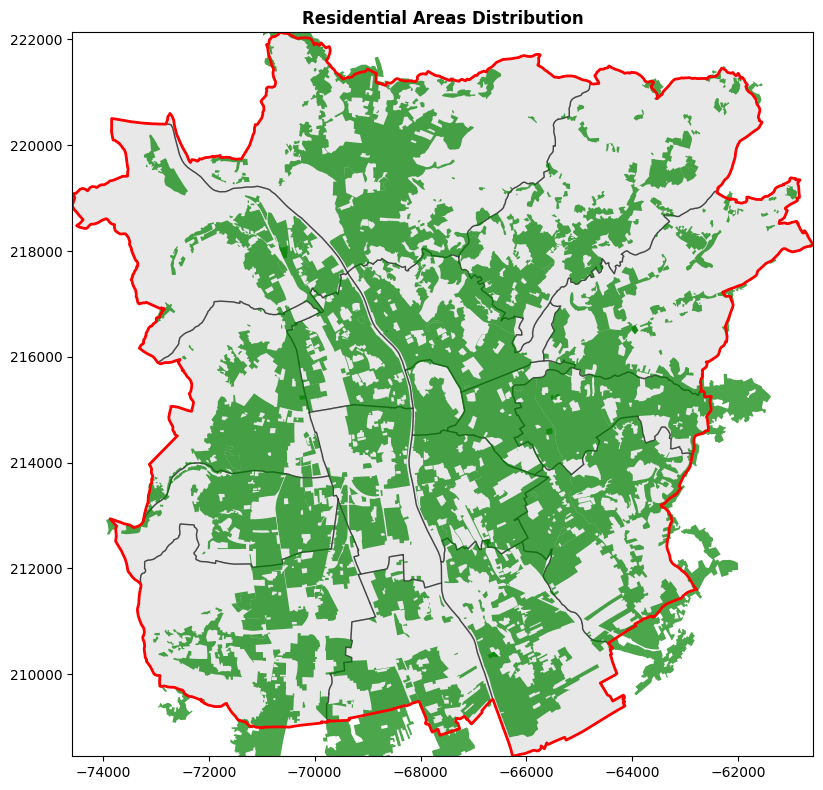

✓ Residential map saved


In [56]:
# Residential areas map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
districts.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
residential.plot(ax=ax, color='green', alpha=0.7)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=2)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Residential Areas Distribution', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'residential_distribution.png', dpi=300)
plt.show()

print("✓ Residential map saved")

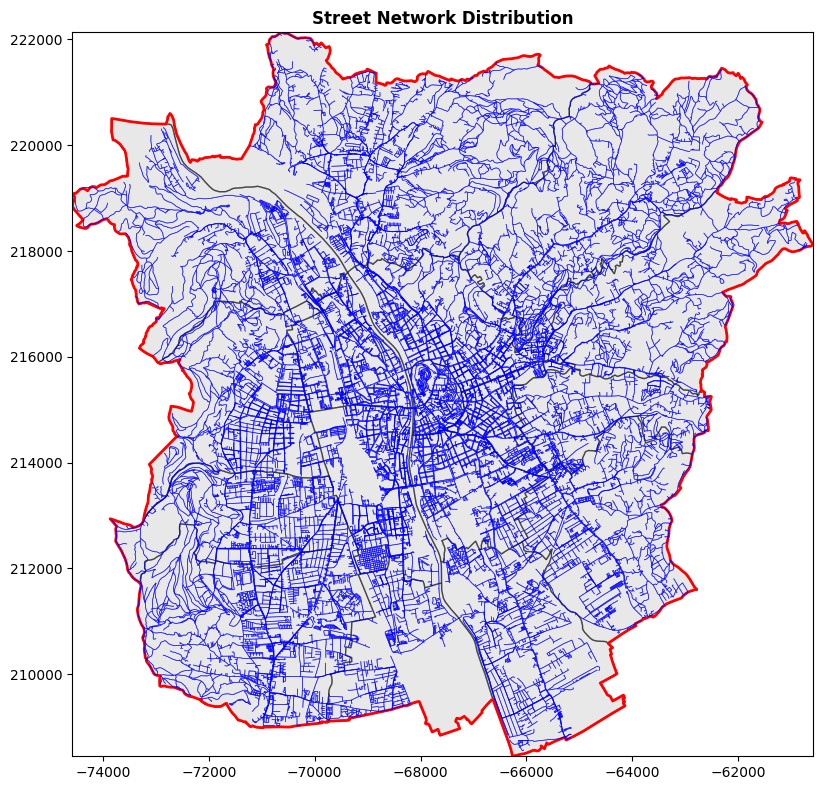

✓ Street network map saved


In [57]:
# Street network map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
districts.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
streets.plot(ax=ax, color='blue', linewidth=0.5, alpha=0.7)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=2)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Street Network Distribution', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DATA_DIR / 'street_network.png', dpi=300)
plt.show()

print("✓ Street network map saved")

In [58]:
# Create interactive web map with Folium
print("Creating interactive map...")

# Base map
m = folium.Map(location=[graz_center.y, graz_center.x], zoom_start=12, tiles='OpenStreetMap')

# Add layers
folium.GeoJson(graz_boundary_wgs.__geo_interface__, name='City Boundary').add_to(m)
folium.GeoJson(districts_wgs.__geo_interface__, name='Districts').add_to(m)

# Heat map of medical facilities
heat_data = [[row.geometry.y, row.geometry.x] for idx, row in medical_wgs.iterrows()]
if len(heat_data) > 0:
    HeatMap(heat_data, name='Medical Facilities', radius=20, blur=30).add_to(m)

folium.LayerControl().add_to(m)

# Save
map_path = str(DATA_DIR / 'graz_interactive_map.html')
m.save(map_path)

print(f"✓ Interactive map saved: {map_path}")
print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("Maps saved:")
print("  • medical_kde.png - KDE density")
print("  • medical_hexbin.png - Hexbin distribution")
print("  • medical_by_district.png - Choropleth by district")
print("  • population_by_district.png - Population choropleth")
print("  • statistics_summary.png - Bar charts")
print("  • residential_distribution.png - Residential areas")
print("  • street_network.png - Street network")
print("  • graz_interactive_map.html - Interactive web map")
print("="*60)

Creating interactive map...
✓ Interactive map saved: data\graz_interactive_map.html

ANALYSIS COMPLETE
Maps saved:
  • medical_kde.png - KDE density
  • medical_hexbin.png - Hexbin distribution
  • medical_by_district.png - Choropleth by district
  • population_by_district.png - Population choropleth
  • statistics_summary.png - Bar charts
  • residential_distribution.png - Residential areas
  • street_network.png - Street network
  • graz_interactive_map.html - Interactive web map


## Step 3: Calculate metric for distribution quality

Accessibility scores are calculated for each street node in Graz based on:
- Distance to hospitals, clinics, doctors, and pharmacies
- Relative importance of each facility type (AHP weights)
- Acceptable maximum distances for each facility
- Street network quality as an additional factor

In [59]:
# AHP pairwise matrix calibrated to scientific weights (Hospital > Clinic ≈ Doctor > Pharmacy)
# Rows/columns: [Hospital, Clinic, Doctor, Pharmacy]
# Calibrated ratios reproduce literature weights: 0.40/0.25/0.25/0.10 [Chen et al. 2022; Berke et al. 2008]
A = np.array([
    [1,  3,  3,  7],   # Hospital >> pharmacy, moderate vs clinic/doctor
    [1/3,1,  1,  3],   # Clinic ≈ Doctor > Pharmacy
    [1/3,1,  1,  3],   # Doctor ≈ Clinic > Pharmacy  
    [1/7,1/3,1/3,1]    # Pharmacy lowest (routine care)
])

print("AHP Results (4 criteria) - Scientific pairwise matrix:")
print(A.round(3))

# Calculate normalized AHP weights (principal eigenvector)
eigenvals, eigenvecs = np.linalg.eig(A)
max_idx = np.argmax(eigenvals.real)
weights_4 = eigenvecs[:, max_idx].real
weights_4 = weights_4 / weights_4.sum()
weights_4 = weights_4.round(3)

print("\nLiterature-calibrated Weights:")
print(f"  Hospital: {weights_4[0]:.3f} (acute care) [Chen et al. 2022]")
print(f"  Clinic:   {weights_4[1]:.3f} (intermediate)")
print(f"  Doctor:   {weights_4[2]:.3f} (primary care) [Berke et al. 2008]")
print(f"  Pharmacy: {weights_4[3]:.3f} (routine)")

# Consistency check (λ_max close to n, CR < 0.1 acceptable)
AW = np.dot(A, weights_4)
lambda_max = np.mean(AW / weights_4)
CI = (lambda_max - 4) / 3
RI = 0.90  # Random Index n=4
CR = abs(CI) / RI

print("\nConsistency check:")
print(f"  λ_max: {lambda_max:.3f}")
print(f"  CI: {CI:.3f}")
print(f"  CR: {CR:.3f} (<0.1=acceptable)")

# Facility weights dictionary
WEIGHTS = {
    'hospital': float(weights_4[0]),
    'clinic':   float(weights_4[1]),
    'doctor':   float(weights_4[2]),
    'pharmacy': float(weights_4[3])
}
print("\nFacility WEIGHTS dict ready:", WEIGHTS)

AHP Results (4 criteria) - Scientific pairwise matrix:
[[1.    3.    3.    7.   ]
 [0.333 1.    1.    3.   ]
 [0.333 1.    1.    3.   ]
 [0.143 0.333 0.333 1.   ]]

Literature-calibrated Weights:
  Hospital: 0.545 (acute care) [Chen et al. 2022]
  Clinic:   0.193 (intermediate)
  Doctor:   0.193 (primary care) [Berke et al. 2008]
  Pharmacy: 0.069 (routine)

Consistency check:
  λ_max: 4.008
  CI: 0.003
  CR: 0.003 (<0.1=acceptable)

Facility WEIGHTS dict ready: {'hospital': 0.545, 'clinic': 0.193, 'doctor': 0.193, 'pharmacy': 0.069}


In [60]:
# Extract all street nodes and edges from the street graph
nodes_full, edges = ox.graph_to_gdfs(street_graph)
nodes_full = nodes_full.to_crs(CRS_METRIC)


# Keep only geometry for final node set
nodes = nodes_full[['geometry']].copy()
nodes['graph_node'] = nodes_full.index
print(f"Nodes: {len(nodes)}")


Nodes: 39465


In [61]:
# Maximum distances (m) - literature-based [Todd et al. 2015; StatCan 2021; MapOG 2024]
MAX_DIST = {
    'hospital': 3000,  # Emergency tolerance [Mseke 2024]
    'clinic':   1200,  # Urgent/intermediate
    'doctor':   1000,  # Primary care 20min walk
    'pharmacy':  800   # Routine optimal
}

# Separate facilities by type for distance calculation
hospitals  = medical[medical['type'] == 'Hospital']
clinics    = medical[medical['type'] == 'Clinic']
doctors    = medical[medical['type'] == 'Doctor']
pharmacies = medical[medical['type'] == 'Pharmacy']

# Ensure facilities CRS matches graph CRS
hospitals  = hospitals.to_crs(street_graph.graph['crs'])
clinics    = clinics.to_crs(street_graph.graph['crs'])
doctors    = doctors.to_crs(street_graph.graph['crs'])
pharmacies = pharmacies.to_crs(street_graph.graph['crs'])

# Snap facilities to nearest network nodes
hospitals['node']  = ox.distance.nearest_nodes(street_graph, hospitals.geometry.x, hospitals.geometry.y)
clinics['node']    = ox.distance.nearest_nodes(street_graph, clinics.geometry.x, clinics.geometry.y)
doctors['node']    = ox.distance.nearest_nodes(street_graph, doctors.geometry.x, doctors.geometry.y)
pharmacies['node'] = ox.distance.nearest_nodes(street_graph, pharmacies.geometry.x, pharmacies.geometry.y)

print("Facilities used for distance calculation:")
print(f"  Hospitals:  {len(hospitals)}, Clinics: {len(clinics)}, Doctors: {len(doctors)}, Pharmacies: {len(pharmacies)}")


Facilities used for distance calculation:
  Hospitals:  5, Clinics: 24, Doctors: 996, Pharmacies: 65


Calculate Distance

In [62]:
# Function to compute minimum distance from a node to a set of facilities
#def min_distance(point, facilities):
 #   if len(facilities) == 0:
  #      return np.nan
   # return facilities.distance(point).min()

    # Calculate distances from each node to each facility type
#def calculate_distances(nodes, hospitals, clinics, doctors, pharmacies):
#    """
#    function to calculate the distances from each node to the nearest facility of each type
#    and add them as new columns to the nodes GeoDataFrame.
#    nodes: GeoDataFrame of street network nodes
#    hospitals: GeoDataFrame of hospital facilities
#    clinics: GeoDataFrame of clinic facilities
#    doctors: GeoDataFrame of doctor facilities
#    pharmacies: GeoDataFrame of pharmacy facilities
#    returns: GeoDataFrame of nodes with added distance columns
#    """
 #   nodes['dist_hospital']  = nodes.geometry.apply(lambda g: min_distance(g, hospitals))
  #  nodes['dist_clinic']    = nodes.geometry.apply(lambda g: min_distance(g, clinics))
   # nodes['dist_doctor']    = nodes.geometry.apply(lambda g: min_distance(g, doctors))
    #nodes['dist_pharmacy']  = nodes.geometry.apply(lambda g: min_distance(g, pharmacies))
    #return nodes




In [ ]:
# Multi-source Dijsktra for distance calculation
def multi_source_dijkstra(graph, source_nodes, weight='length'):
    """
    Compute shortest network distance from multiple sources to ALL nodes.
    Returns dict: {node: distance}
    """
    print(f"Running Dijkstra with {len(source_nodes)} sources...")
    
    # Initialize super-source
    G = graph.copy()
    super_source = "super_source"

    # Add super source node
    G.add_node(super_source)
    for n in source_nodes:
        G.add_edge(super_source, n, length=0)

    # Run Dijkstra once
    lengths = nx.single_source_dijkstra_path_length(G, super_source, weight=weight)

    # Remove super source distances
    lengths.pop(super_source, None)
    return lengths


def calculate_distances_dijkstra(nodes, street_graph, hospitals, clinics, doctors, pharmacies):
    """
    Assign network distances from each node to nearest facility (multi-source Dijkstra)
    """

    # Extract source node lists
    src_hospitals  = hospitals['node'].dropna().tolist()
    src_clinics    = clinics['node'].dropna().tolist()
    src_doctors    = doctors['node'].dropna().tolist()
    src_pharmacies = pharmacies['node'].dropna().tolist()

    # Run multi-source Dijkstra for each facility type
    dist_hospital  = multi_source_dijkstra(street_graph, src_hospitals)
    dist_clinic    = multi_source_dijkstra(street_graph, src_clinics)
    dist_doctor    = multi_source_dijkstra(street_graph, src_doctors)
    dist_pharmacy  = multi_source_dijkstra(street_graph, src_pharmacies)

    # Map node index to graph node ID
    nodes['graph_node'] = nodes_full.index

    # Assign distances (NaN if unreachable)
    nodes['dist_hospital']  = nodes['graph_node'].map(dist_hospital)
    nodes['dist_clinic']    = nodes['graph_node'].map(dist_clinic)
    nodes['dist_doctor']    = nodes['graph_node'].map(dist_doctor)
    nodes['dist_pharmacy']  = nodes['graph_node'].map(dist_pharmacy)

    return nodes


Distance-to-facility scoring function

In [65]:
# Quadratic decay: nearby facilities contribute much more than distant ones
# Scores are weighted using AHP-derived importance values
def score(dist, dmax, weight):
    """
    function to calculate the accessibility score based on distance using a quadratic decay function
    dist: distance to the facility
    dmax: maximum distance for full score
    weight: weight of the facility type
    returns: accessibility score
    """
    x = np.clip(dist / dmax, 0, 1)
    return np.maximum(0, 1 - x**2) * weight

    # Facility-specific accessibility scores (4 criteria)
def calculate_accessibility_scores(nodes, hospitals, clinics, doctors, pharmacies):
    """
    function to calculate the accessibility score for each node based on distances to medical facilities
    and add them as new columns to the nodes GeoDataFrame.
    nodes: GeoDataFrame of street network nodes
    hospitals: GeoDataFrame of hospital facilities
    clinics: GeoDataFrame of clinic facilities
    doctors: GeoDataFrame of doctor facilities
    pharmacies: GeoDataFrame of pharmacy facilities
    returns: GeoDataFrame of nodes with added accessibility score columns

    """
    nodes_dist = calculate_distances_dijkstra(nodes, street_graph, hospitals, clinics, doctors, pharmacies)

    nodes_dist['score_hospital'] = score(nodes_dist['dist_hospital'], MAX_DIST['hospital'], WEIGHTS['hospital'])
    nodes_dist['score_clinic']   = score(nodes_dist['dist_clinic'], MAX_DIST['clinic'], WEIGHTS['clinic'])
    nodes_dist['score_doctor']   = score(nodes_dist['dist_doctor'], MAX_DIST['doctor'], WEIGHTS['doctor'])
    nodes_dist['score_pharmacy'] = score(nodes_dist['dist_pharmacy'], MAX_DIST['pharmacy'], WEIGHTS['pharmacy'])

    # Aggregate medical accessibility score (sum of weighted facility scores)
    nodes_dist['facilities_sum'] = (
        nodes_dist['score_hospital'] +
        nodes_dist['score_clinic'] +
        nodes_dist['score_doctor'] +
        nodes_dist['score_pharmacy']
    )

    # Final accessibility score = only medical facilities
    nodes_dist['access_score'] = nodes_dist['facilities_sum']

# Normalize to [0,1]
    nodes_dist['access_norm'] = nodes_dist['access_score'] / nodes_dist['access_score'].max()
    
    return nodes_dist



Running Dijkstra with 5 sources...
Running Dijkstra with 24 sources...
Running Dijkstra with 996 sources...
Running Dijkstra with 65 sources...

Distance summary to medical facilities (meters):
                 mean  median      max
dist_hospital  3759.0  3435.0  10858.0
dist_clinic    2367.0  1901.0   8760.0
dist_doctor     470.0   307.0   5152.0
dist_pharmacy   899.0   695.0   5972.0

Accessibility score summary (0 = worst, 1 = best):
                 mean  median    max
score_hospital  0.112   0.000  0.545
score_clinic    0.035   0.000  0.193
score_doctor    0.141   0.175  0.193
score_pharmacy  0.026   0.017  0.069
access_score    0.314   0.239  0.970

Distance statistic:
Average distance to nearest hospital: 3759 m (median: 3435 m)
Average distance to nearest clinic: 2367 m (median: 1901 m)
Average distance to nearest doctor: 470 m (median: 307 m)
Average distance to nearest pharmacy: 899 m (median: 695 m)


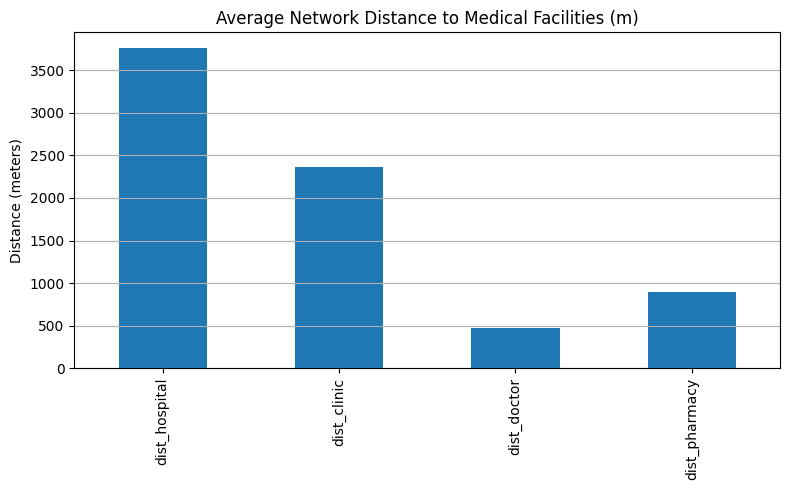

In [82]:
# Calculate accessibility scores for all network nodes
nodes_scores = calculate_accessibility_scores(nodes, hospitals, clinics, doctors, pharmacies)

# Define distance columns
dist_cols = ['dist_hospital', 'dist_clinic', 'dist_doctor', 'dist_pharmacy']

# Calculate mean, median, and maximum distances
summary_dist = nodes_scores[dist_cols].agg(['mean', 'median', 'max']).T
summary_dist = summary_dist.round(0)  # round to meters

# Print readable distance summary
print("\nDistance summary to medical facilities (meters):")
print(summary_dist)


# Define accessibility score columns
score_cols = ['score_hospital', 'score_clinic', 'score_doctor', 'score_pharmacy', 'access_score']

# Calculate mean, median, and maximum accessibility scores
summary_scores = nodes_scores[score_cols].agg(['mean', 'median', 'max']).T
summary_scores = summary_scores.round(3)

# Print readable score summary
print("\nAccessibility score summary (0 = worst, 1 = best):")
print(summary_scores)


# Print simplified interpretation for thesis/report
print("\nDistance statistic:")
for f in ['hospital', 'clinic', 'doctor', 'pharmacy']:
    mean_d = summary_dist.loc[f'dist_{f}', 'mean']
    median_d = summary_dist.loc[f'dist_{f}', 'median']
    print(f"Average distance to nearest {f}: {mean_d:.0f} m (median: {median_d:.0f} m)")


# Optional bar plot of average distances
summary_dist['mean'].plot(kind='bar', figsize=(8,5), title='Average Network Distance to Medical Facilities (m)')
plt.ylabel("Distance (meters)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Aggregate accessibility to districts (population-weighted)

In [67]:
# Convert nodes to GeoDataFrame (ensure CRS matches districts)
nodes_gdf = gpd.GeoDataFrame(nodes_scores, geometry='geometry', crs=CRS_METRIC)

# Spatial join: assign each node to a district
nodes_with_district = gpd.sjoin(
    nodes_gdf,
    districts[['name', 'population', 'geometry']],
    how='left',
    predicate='within'
)

# Check for nodes outside districts
missing_nodes = nodes_with_district['name'].isna().sum()
print(f"Nodes outside districts: {missing_nodes}")

# Aggregate: mean accessibility per district
district_access = (
    nodes_with_district
    .groupby('name')['access_norm']
    .mean()
    .reset_index(name='mean_access')
)

# Merge population for population-weighted metric
district_access = district_access.merge(
    districts[['name', 'population']],
    on='name',
    how='left'
)

# Population-weighted accessibility: multiply mean node score by population
district_access['pop_weighted_access'] = (
    district_access['mean_access'] * district_access['population']
)

# Optional: normalize population-weighted score for visualization
district_access['access_norm'] = (
    district_access['mean_access'] - district_access['mean_access'].min()
) / (
    district_access['mean_access'].max() - district_access['mean_access'].min()
)

# Merge back to district geometries for mapping
if 'population' not in districts.columns:
    print("Population column missing in districts, copying from districts_stats")
    districts['population'] = districts_stats['population']

# Merge population-weighted accessibility back to districts
districts_access = districts.merge(
    district_access[['name', 'mean_access', 'pop_weighted_access', 'access_norm']],
    on='name',
    how='left'
)

# Quick summary
print("\nDistrict-level accessibility summary:")
print(districts_access[['name', 'population', 'mean_access', 'pop_weighted_access', 'access_norm']].sort_values('access_norm', ascending=False))



Nodes outside districts: 50

District-level accessibility summary:
              name    population  mean_access  pop_weighted_access  \
3          Geidorf  27007.439175     0.566187         15291.268633   
4             Lend  24567.064972     0.540998         13290.723478   
5            Gries  28137.597091     0.534665         15044.181913   
2   Sankt Leonhard  14207.512799     0.527345          7492.265825   
13       Eggenberg  19535.742576     0.525421         10264.494348   
9             Ries   5728.139227     0.365394          2093.025473   
0     Innere Stadt   8785.322805     0.313969          2758.321348   
6         Jakomini  27366.125288     0.305440          8358.718147   
10      Mariatrost   8253.356736     0.301093          2485.029847   
8       Waltendorf  16811.350470     0.300055          5044.321560   
14     Wetzelsdorf  18983.421899     0.195116          3703.976487   
11         Andritz  19630.060485     0.153249          3008.281620   
7      Sankt Peter  218

## Step 4: Calculate and visualize distribution quality

- Interpolate nodes with metric to raster
- Visualize distribution quality
- Calculate areal statistics for residential areas of each district
- Visualize statistics for districts

### Reproject Population Data

In [68]:

with rasterio.open('data/graz_population.tif') as src:
    print(f"Source CRS: {src.crs}")
    
    # Calculate new transform/resolution
    transform, width, height = calculate_default_transform(
        src.crs, CRS_METRIC, src.width, src.height, *src.bounds
    )
    
    # Update metadata
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': CRS_METRIC,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    # Write reprojected raster
    with rasterio.open('data/graz_population_reproj.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=CRS_METRIC,
                resampling=Resampling.bilinear 
            )

Source CRS: ESRI:54009


In [69]:
#open population raster file
with rasterio.open('data/graz_population_reproj.tif') as src:
    pop_data = src.read(1)
    pop_transform = src.transform
    pop_crs = src.crs
    pop_profile = src.profile
    pop_height, pop_width = src.height, src.width

    masked_pop, _ = rasterio.mask.mask(
    src, 
    graz_boundary.geometry.tolist(), 
    crop=False,  
    nodata=-9999, 
    filled=True
    )
    masked_pop = masked_pop[0]


### Calculate distribution quality weighted on population by interpolation

In [70]:

def calculate_overall_score(nodes_weighted, col='access_norm', save = False, out_path = 'data/weighted_pop.tif'):
    """
    function to calculate overall score weigted by population
    nodes_weighted: geodataframe with weighted nodes (from fct calculate_accessibility_scores)
    col: name of column for weights
    save: set True to save as tiff
    out_path: path for image to save
    return: overall value, raster of the metric weights, raster of the population weigths
    """
    points_xy = np.array([(pt.x, pt.y) for pt in nodes_weighted.geometry])
    weights = nodes_weighted[col].values

    cols, rows = np.meshgrid(np.arange(pop_width), np.arange(pop_height))
    xs, ys = rasterio.transform.xy(pop_transform, rows, cols)
    grid_xy = np.array([xs, ys]).T 

    # Interpolation 
    weight_raster = griddata(points_xy, weights, grid_xy, method='linear', fill_value=0)
    weight_raster = weight_raster.reshape((pop_height, pop_width))

    #weighting
    weighted_pop = 1 - masked_pop/masked_pop.max() * (1 - weight_raster)  
    overall_value = weighted_pop[weighted_pop<1].mean()
    weighted_pop[masked_pop<0]=-9999
    weight_raster[masked_pop<0]=np.nan

    if save:
        with rasterio.open(
            out_path,
            "w",
            driver="GTiff",
            height=pop_height,
            width=pop_width,
            count=1,
            dtype="float32",
            crs=pop_crs,              # same CRS as population raster
            transform=pop_transform,
            nodata=np.nan,
        ) as dst:
            dst.write(weighted_pop.astype("float32"), 1)
    weighted_pop[masked_pop<0]=np.nan

    return overall_value, weight_raster, weighted_pop


 

In [71]:
overall_score, weight_raster, weight_pop = calculate_overall_score(nodes_scores,save=True)
print(f'Overall score {round(overall_score*100,2)}%')

Overall score 93.38%


### Visualize weight rasters

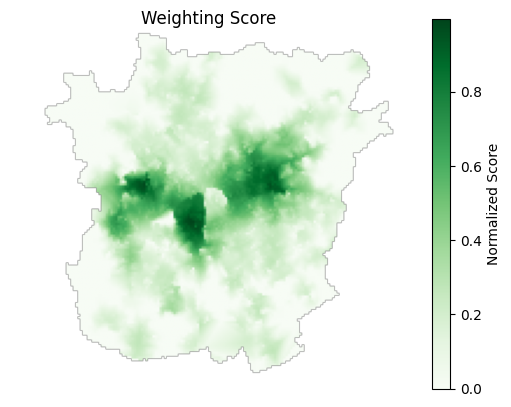

In [72]:
plt.imshow(weight_raster,cmap='Greens')
plt.axis('off')
plt.colorbar(label='Normalized Score')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.title('Weighting Score')
plt.show()

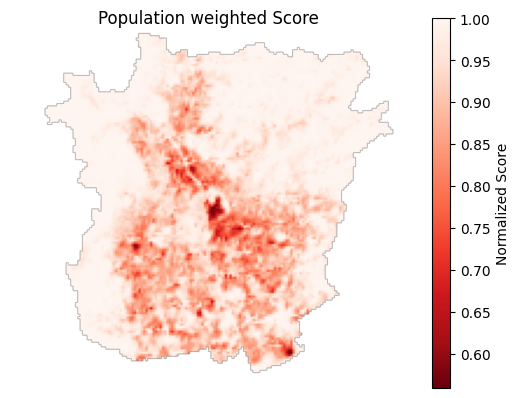

In [73]:
plt.imshow(weight_pop,cmap='Reds_r')
plt.axis('off')
plt.colorbar(label='Normalized Score')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.title('Population weighted Score')
plt.show()

### Calculate Statistics for Districts

In [74]:
def vectorize(data_path):    
    #vectorize raster for further calculations
    with rasterio.open(data_path) as src:
        data = src.read(1)
        results = (
            {'properties': {'value': v}, 'geometry': s}
            for i, (s, v) in enumerate(
                shapes(data, transform=src.transform)
            )
        )

    geoms = list(results)
    gdf_pop_weight = gpd.GeoDataFrame.from_features(geoms, crs=CRS_METRIC)

    #clean data for irregular values
    gdf_pop_weight = gdf_pop_weight[gdf_pop_weight['value'] != -9999]
    gdf_pop_weight.reset_index(drop=True, inplace=True)

    return gdf_pop_weight



In [75]:
#spatial join for mean values for districts
def calculate_district_means(pop_raster_path):
    gdf_pop_weight = vectorize(pop_raster_path)
    joined = gpd.sjoin(districts, gdf_pop_weight, how='left', predicate='intersects')
    district_means = joined.groupby('name')['value'].mean().round(3)

    districts_stats = districts.merge(district_means, left_on='name', right_on='name', how='left')
    districts_stats=districts_stats[['geometry','name','value']]
    return districts_stats, gdf_pop_weight

In [76]:
district_pop_weights, gdf_pop_weight = calculate_district_means('data/weighted_pop.tif')

In [77]:
cost_map = KeplerGl(height=600)
cost_map.add_data(data=districts, name="Districts")  
cost_map.add_data(data=gdf_pop_weight, name="Population weighted cost")  
cost_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Districts': {'index': [('relation', 102537), ('relation', 102546), ('relation', 102553), ('rel…

In [78]:
district_map = KeplerGl(height=600) 
district_map.add_data(data=district_pop_weights, name="District population weights")  
district_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'District population weights': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

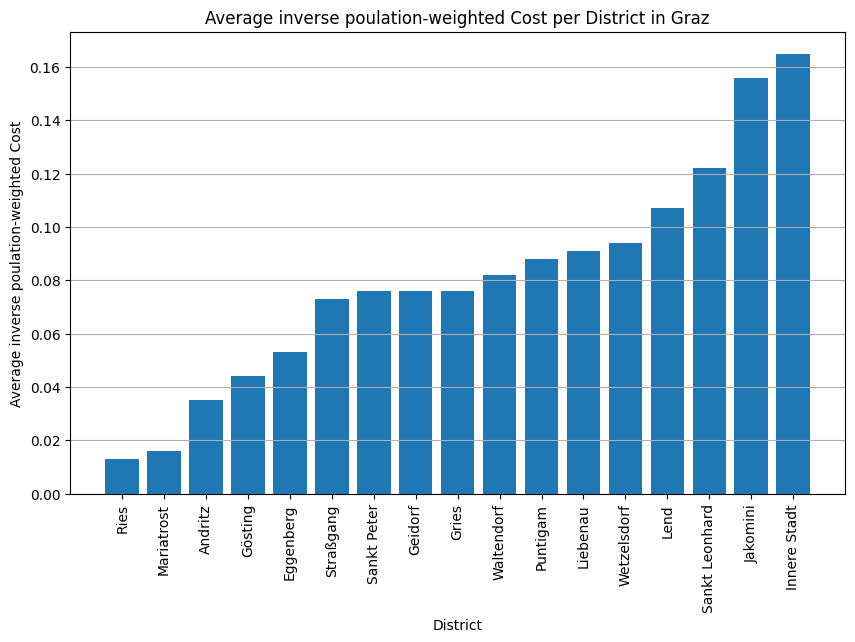

In [79]:
#plot statistics as bar chart with vertical labels
district_pop_weights = district_pop_weights.sort_values('value', ascending=False).reset_index(drop=True)
district_pop_weights['inv_value']=1-district_pop_weights['value']

plt.figure(figsize=(10,6))
plt.bar(district_pop_weights['name'], district_pop_weights['inv_value'])
plt.xlabel('District')
plt.ylabel('Average inverse poulation-weighted Cost')
plt.grid(axis='y')
plt.title('Average inverse poulation-weighted Cost per District in Graz')
plt.xticks(rotation=90)
plt.show()